# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

!mkdir cifar10
!sudo curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

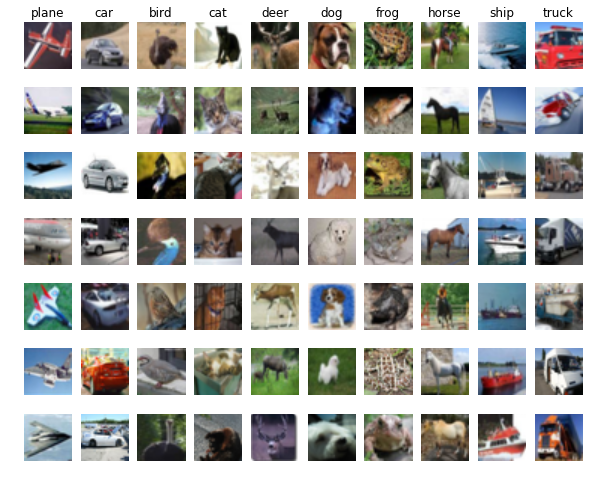

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

    Больше, сложнее, глубже.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

    Проблема инициализации весов (матриц). Затухание градиентов из-за слишком большой глубины. Слишком большое время работы.


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

    Слишком мало данных. Возможно быстрое переобучение. С помощью data augmentation, т.е. поворотов, кропов, флипов и других преобразований исходных картинок увеличить трейн.
    
**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

    Взять спектрограмму музыки (Фурье преобразование) - 2D матрица, применить к ней style transfer как к картинке, например VGG19, и затем восстановить обратно сигнал по измененной спектрограмме.

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:04.0)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

Отнормируем данные (поделим на максимум и вычтем среднее). Затем добавим флипы - разворот каждого изображения. Таким образом увеличим размер трейна.

In [5]:
X_train = X_train / np.float32(255)
X_test = X_test / np.float32(255)
m = np.mean(X_train, axis=0)
X_train = X_train - m
X_test = X_test - m

X_train_flip = X_train[:,:,:,::-1]
y_train_flip = y_train
X_train = np.concatenate((X_train, X_train_flip), axis=0)
y_train = np.concatenate((y_train, y_train_flip), axis=0)

In [6]:
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import GlobalPoolLayer
from lasagne.layers import PadLayer
from lasagne.layers import ExpressionLayer
from lasagne.layers import NonlinearityLayer
from lasagne.nonlinearities import softmax, rectify
from lasagne.layers import batch_norm

def build_cnn(input_var=None, n=5):
    
    # create a residual learning building block with two stacked 3x3 convlayers as in paper
    def residual_block(l, increase_dim=False, projection=False):
        input_num_filters = l.output_shape[1]
        if increase_dim:
            first_stride = (2,2)
            out_num_filters = input_num_filters*2
        else:
            first_stride = (1,1)
            out_num_filters = input_num_filters

        stack_1 = batch_norm(ConvLayer(l, num_filters=out_num_filters, filter_size=(3,3), 
                                       stride=first_stride, nonlinearity=rectify, pad='same', 
                                       W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
        stack_2 = batch_norm(ConvLayer(stack_1, num_filters=out_num_filters, filter_size=(3,3), 
                                       stride=(1,1), nonlinearity=None, pad='same', 
                                       W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
        
        # add shortcut connections
        if increase_dim:
            if projection:
                # projection shortcut, as option B in paper
                projection = batch_norm(ConvLayer(l, num_filters=out_num_filters, filter_size=(1,1), 
                                                  stride=(2,2), nonlinearity=None, pad='same', 
                                                  b=None, flip_filters=False))
                block = NonlinearityLayer(ElemwiseSumLayer([stack_2, projection]),nonlinearity=rectify)
            else:
                # identity shortcut, as option A in paper
                identity = ExpressionLayer(l, lambda X: X[:, :, ::2, ::2], 
                                           lambda s: (s[0], s[1], s[2]//2, s[3]//2))
                padding = PadLayer(identity, [out_num_filters//4,0,0], batch_ndim=1)
                block = NonlinearityLayer(ElemwiseSumLayer([stack_2, padding]),nonlinearity=rectify)
        else:
            block = NonlinearityLayer(ElemwiseSumLayer([stack_2, l]),nonlinearity=rectify)
        
        return block

    # Building the network
    l_in = InputLayer(shape=(None, 3, 32, 32), input_var=input_var)

    # first layer, output is 16 x 32 x 32
    l = batch_norm(ConvLayer(l_in, num_filters=16, filter_size=(3,3), stride=(1,1), 
                             nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), 
                             flip_filters=False))
    
    # first stack of residual blocks, output is 16 x 32 x 32
    for _ in range(n):
        l = residual_block(l)

    # second stack of residual blocks, output is 32 x 16 x 16
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)

    # third stack of residual blocks, output is 64 x 8 x 8
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)
    
    # average pooling
    l = GlobalPoolLayer(l)

    # fully connected layer
    network = DenseLayer(
            l, num_units=10,
            W=lasagne.init.HeNormal(),
            nonlinearity=softmax)

    return network

При $n=9$ получаем ResNet54

In [33]:
net2 = build_cnn(input_var=input_X, n=9)

Добавим к функции потерь L2 регуляризатор

In [34]:
y_predicted = lasagne.layers.get_output(net2)
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y)
loss = loss.mean()
all_layers = lasagne.layers.get_all_layers(net2)
l2_penalty = lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.0001
loss = loss + l2_penalty

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

Будем использовать моментум, так как с ним вышло лучше. Learning_rate делаем shared переменной, чтобы уменьшать его в процессе обучения

In [35]:
params = lasagne.layers.get_all_params(net2, trainable=True)
lr = 0.1
sh_lr = theano.shared(lasagne.utils.floatX(lr))
updates = lasagne.updates.momentum(
        loss, params, learning_rate=sh_lr, momentum=0.9)

train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

In [36]:
all_weights = lasagne.layers.get_all_params(net2)
print all_weights

[W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta

### Вот и всё, пошли её учить

Добавим data augmentation, так как это сильно улучшает качество. Флипы мы добавили в трейн, теперь для каждого минибатча будет делать произвольный crop - обрезание картинки, и паддинг.

In [37]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

In [38]:
import time

num_epochs = 70 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    if epoch == 40 or epoch == 60: # наилучший момент уменьшия l_r
        new_lr = sh_lr.get_value() * 0.1
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

/home/xdr007/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


Epoch 1 of 70 took 248.943s
  training loss (in-iteration):		2.570409
  train accuracy:		31.23 %
  validation accuracy:		51.05 %
Epoch 2 of 70 took 248.718s
  training loss (in-iteration):		1.738468
  train accuracy:		56.57 %
  validation accuracy:		63.64 %
Epoch 3 of 70 took 248.866s
  training loss (in-iteration):		1.345167
  train accuracy:		68.48 %
  validation accuracy:		73.61 %
Epoch 4 of 70 took 249.274s
  training loss (in-iteration):		1.121178
  train accuracy:		74.76 %
  validation accuracy:		77.43 %
Epoch 5 of 70 took 249.401s
  training loss (in-iteration):		0.983958
  train accuracy:		77.98 %
  validation accuracy:		78.76 %
Epoch 6 of 70 took 249.566s
  training loss (in-iteration):		0.898225
  train accuracy:		80.18 %
  validation accuracy:		80.12 %
Epoch 7 of 70 took 249.477s
  training loss (in-iteration):		0.835352
  train accuracy:		81.70 %
  validation accuracy:		81.26 %
Epoch 8 of 70 took 248.984s
  training loss (in-iteration):		0.793521
  train accuracy:		82.99 %


KeyboardInterrupt: 

Так как нужное качество достиглось раньше, прервем обучение, так как выше качество поднимется не сильно (проверял), а учится не быстро.

Сохраним веса модели в файл

In [39]:
np.savez('modelresnet54.npz', *lasagne.layers.get_all_param_values(net2))

In [40]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		92.79 %
Achievement unlocked: колдун 80 уровня


# Дополнительно - попытка обучить VGG до хорошего качества

## VGG

In [15]:
def create_vgg(input_var, input_shape=(3, 32, 32), **junk):
    # input layer
    network = lasagne.layers.InputLayer(shape=(None,) + input_shape,
                                        input_var=input_var)
    # conv-relu-conv-relu-pool layers
    for num_filters in ccp_num_filters:
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.very_leaky_rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.Conv2DLayer(
            network, num_filters=num_filters,
            filter_size=(ccp_filter_size, ccp_filter_size),
            pad='same',
            nonlinearity=lasagne.nonlinearities.very_leaky_rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
        network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    # fc-relu
    for num_units in fc_num_units:
        network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=num_units,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))
    # output layer
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=num_classes,
        nonlinearity=lasagne.nonlinearities.softmax)
    return network

Создадим неполную VGG - (Conv-Conv-Pool)*4 - Dense - Drop - Dense - Drop - Out. Так же будем использовать нелинейность very_leaky_rectify, чтобы не затухал градиент.

In [16]:
param = dict(ccp_num_filters=[64, 128, 256, 512], ccp_filter_size=3,
             fc_num_units=[1024, 1024], num_classes=10)

vgg = create_vgg(input_X, **param)

Будем уменьшать learning_rate в зависимости от эпохи как указано ниже

In [17]:
LR_SCHEDULE = {
    0: 0.001,
    25: 0.0001,
    35: 0.00001,
    45: 0.000001,
    55: 0.0000001
}

In [18]:
y_predicted = lasagne.layers.get_output(vgg, deterministic=True)
all_weights = lasagne.layers.get_all_params(vgg)
print all_weights

[W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b, W, b]


In [19]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [20]:
l_r = theano.shared(np.array(LR_SCHEDULE[0], dtype=theano.config.floatX))

train_fun = theano.function([input_X,target_y],[loss, accuracy], 
                            updates=lasagne.updates.adam(loss, all_weights, learning_rate=l_r), 
                            allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [21]:
import time

num_epochs = 80 #количество проходов по данным

batch_size = 250 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    if epoch in LR_SCHEDULE:
        l_r.set_value(LR_SCHEDULE[epoch])
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size, shuffle=True, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

/home/xdr007/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


Epoch 1 of 80 took 191.535s
  training loss (in-iteration):		1.322589
  train accuracy:		51.83 %
  validation accuracy:		66.72 %
Epoch 2 of 80 took 191.609s
  training loss (in-iteration):		0.749958
  train accuracy:		73.93 %
  validation accuracy:		78.04 %
Epoch 3 of 80 took 191.543s
  training loss (in-iteration):		0.590508
  train accuracy:		79.70 %
  validation accuracy:		80.60 %
Epoch 4 of 80 took 191.541s
  training loss (in-iteration):		0.507436
  train accuracy:		82.55 %
  validation accuracy:		84.17 %
Epoch 5 of 80 took 191.525s
  training loss (in-iteration):		0.454285
  train accuracy:		84.45 %
  validation accuracy:		84.45 %
Epoch 6 of 80 took 191.524s
  training loss (in-iteration):		0.420276
  train accuracy:		85.63 %
  validation accuracy:		84.64 %
Epoch 7 of 80 took 191.620s
  training loss (in-iteration):		0.384233
  train accuracy:		86.86 %
  validation accuracy:		85.11 %
Epoch 8 of 80 took 191.575s
  training loss (in-iteration):		0.366902
  train accuracy:		87.42 %


KeyboardInterrupt: 

Видно, что сетка переобучилась и качества не хватает для порога, но тем не менее качество очень неплохое. Довольно сильно помогло data augmentation и правильное изменения learning rate

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

In [ ]:
np.savez('modelcnn.npz', *lasagne.layers.get_all_param_values(vgg))

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 